# **Question 5 - Yeast Protein Interaction**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from scipy import stats
import time

# PART A

Loaded 2930 interactions
Constructing YPI network...

Analyzing network topology...
Network Statistics:
Number of nodes: 2018
Number of edges: 2930
Network density: 0.001440
Average clustering coefficient: 0.046194
Is the network connected? False
Number of connected components: 185
Size of largest connected component: 1647 nodes
Percentage of nodes in largest component: 81.62%

Plotting degree distribution...
Calculating C(k) x k...


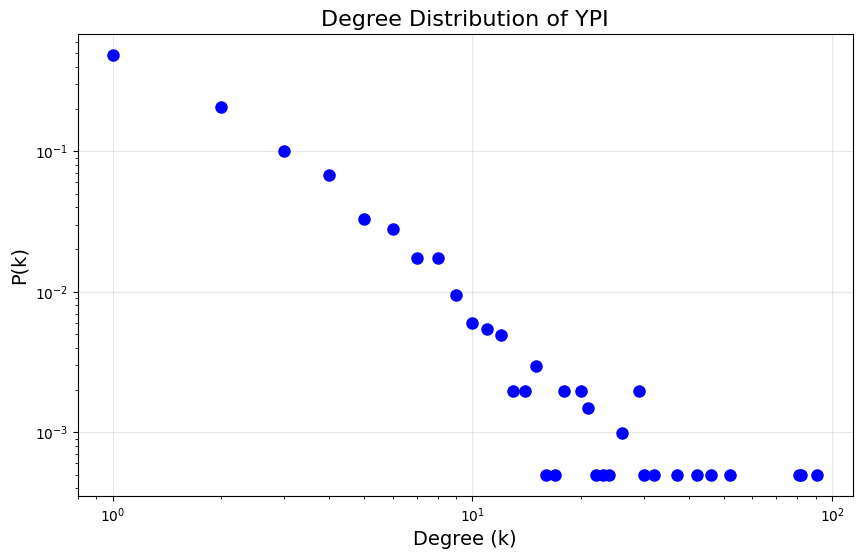

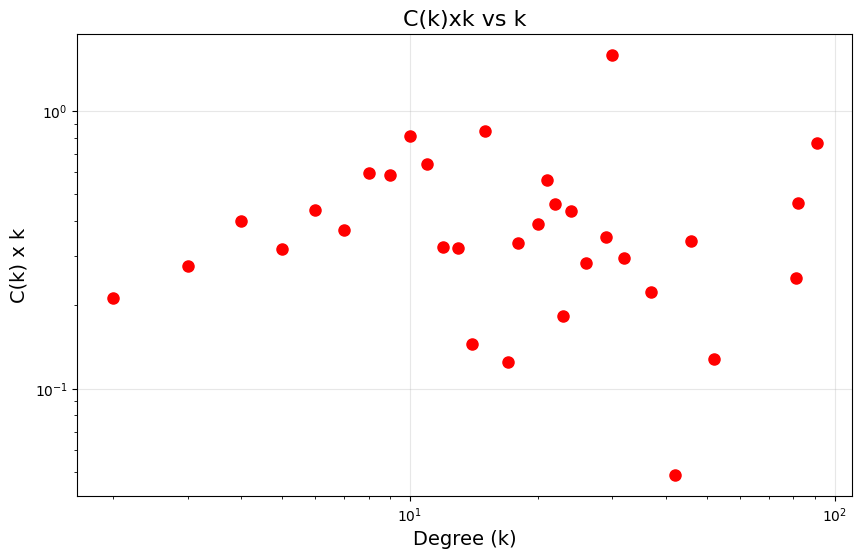

In [12]:
def load_interaction_data(file_path='y2h_union.txt'):
    interactions = pd.read_csv(file_path, sep='\t', header=None, names=['protein1', 'protein2'])
    return interactions

def construct_ypi_network(data):
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(row['protein1'], row['protein2'])
    
    return G

def plot_degree_distribution(G):
    degrees = [d for n, d in G.degree()]
    degree_counts = pd.Series(degrees).value_counts().sort_index()
    pk = degree_counts / sum(degree_counts)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(pk.index, pk.values, 'bo', markersize=8)
    plt.xlabel('Degree (k)', fontsize=14)
    plt.ylabel('P(k)', fontsize=14)
    plt.title('Degree Distribution of YPI', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.savefig('ypi_degree_distribution.png')

    return pk

def calculate_ck_vs_k(G):
    clustering = nx.clustering(G)
    degree_to_nodes = defaultdict(list)
    for node, degree in G.degree():
        degree_to_nodes[degree].append(node)
    
    ck = {}
    for k, nodes in degree_to_nodes.items():
        if k > 1:  # Clustering coefficient is only defined for nodes with degree > 1
            ck[k] = np.mean([clustering[node] for node in nodes])

    ck_times_k = {k: ck[k] * k for k in ck}
    
    # Convert to DataFrame for plotting
    ck_df = pd.DataFrame({'k': list(ck_times_k.keys()), 'C(k) x k': list(ck_times_k.values())}).sort_values('k')
    
    plt.figure(figsize=(10, 6))
    plt.loglog(ck_df['k'], ck_df['C(k) x k'], 'ro', markersize=8)
    plt.xlabel('Degree (k)', fontsize=14)
    plt.ylabel('C(k) x k', fontsize=14)
    plt.title('C(k)xk vs k', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.savefig('ypi_ck_k_plot.png')
    
    return ck_df

def analyze_network_topology(G):
    print(f"Network Statistics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    density = nx.density(G)
    print(f"Network density: {density:.6f}")
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.6f}")
    is_connected = nx.is_connected(G)
    print(f"Is the network connected? {is_connected}")
    
    if not is_connected:
        num_components = nx.number_connected_components(G)
        print(f"Number of connected components: {num_components}")
        largest_cc = max(nx.connected_components(G), key=len)
        print(f"Size of largest connected component: {len(largest_cc)} nodes")
        pct_largest = len(largest_cc) / G.number_of_nodes() * 100
        print(f"Percentage of nodes in largest component: {pct_largest:.2f}%")

def part_a_main():
    interactions_data = load_interaction_data('C://Users//dhvan//Downloads//Sem 8//NetworkScience//Assignment2//Q5_datasets//y2h_union.txt')
    print(f"Loaded {len(interactions_data)} interactions")

    print("Constructing YPI network...")
    G = construct_ypi_network(interactions_data)
    print("\nAnalyzing network topology...")
    analyze_network_topology(G)
    print("\nPlotting degree distribution...")
    pk = plot_degree_distribution(G)
    print("Calculating C(k) x k...")
    ck_df = calculate_ck_vs_k(G)
    
    return G, pk, ck_df

if __name__ == "__main__":
    G, pk, ck_df = part_a_main()

# PART B

Loaded 813 essential genes

Identifying key proteins in the network...
Top 10 proteins by degree:
YLR291C: 91 interactions
YLR423C: 82 interactions
YNL189W: 81 interactions
YIR038C: 52 interactions
YDR510W: 46 interactions
YBR261C: 42 interactions
YDR479C: 37 interactions
YDR100W: 32 interactions
YPL070W: 30 interactions
YDL100C: 29 interactions

Analyzing relationship between essentiality and degree...


C:\Users\dhvan\AppData\Local\Temp\ipykernel_23328\456611149.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_groups = network_data.groupby('degree_bin')


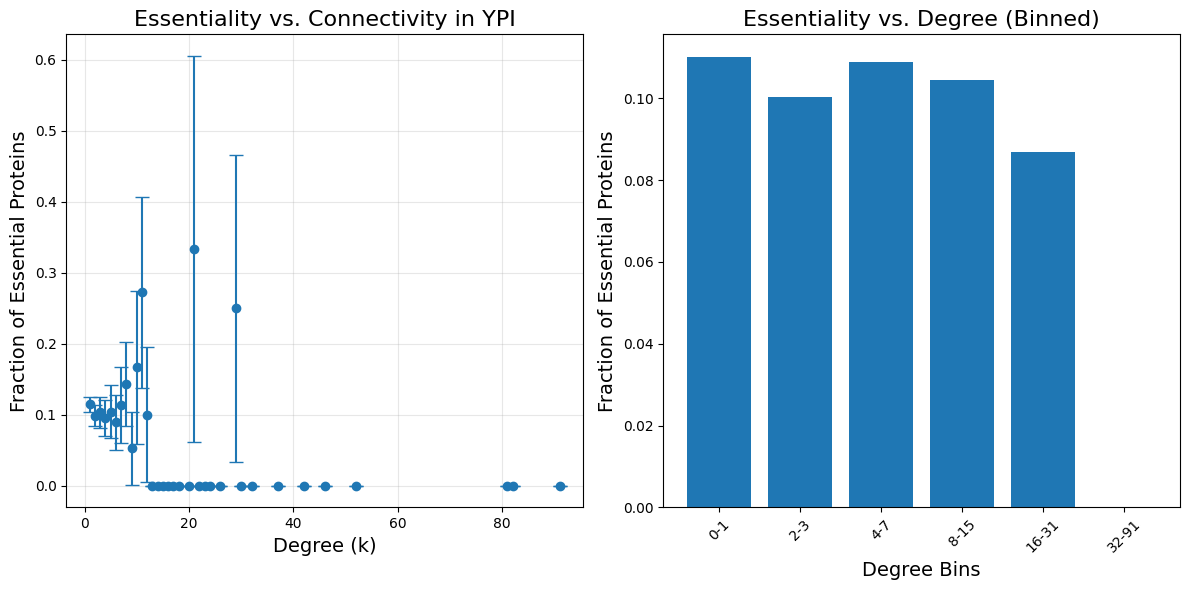

In [13]:
def load_essential_genes(file_path='essential_genes.csv'):
    essential_data = pd.read_csv(file_path)
    return essential_data

def identify_key_proteins(G, top_n=10):
    degree_dict = dict(G.degree())
    sorted_proteins = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    
    top_proteins = sorted_proteins[:top_n]
    
    print(f"Top {top_n} proteins by degree:")
    for protein, degree in top_proteins:
        print(f"{protein}: {degree} interactions")
    
    return top_proteins

def analyze_essentiality_vs_degree(G, essential_data):
    protein_to_essential = dict(zip(essential_data['Gene'], essential_data['Essential']))
    all_proteins_data = []
    for protein in G.nodes():
        all_proteins_data.append({
            'protein': protein,
            'degree': G.degree(protein),
            'essential': protein_to_essential.get(protein, 0)  # Default to 0 if not in essential list
        })
    
    network_data = pd.DataFrame(all_proteins_data)
    degree_groups = network_data.groupby('degree')
    essentiality_by_degree = degree_groups['essential'].mean()
    count_by_degree = degree_groups.size()
    # Standard error = sqrt(p*(1-p)/n) where p is the proportion and n is the sample size
    std_error = np.sqrt(essentiality_by_degree * (1 - essentiality_by_degree) / count_by_degree)

    result_df = pd.DataFrame({
        'degree': essentiality_by_degree.index,
        'fraction_essential': essentiality_by_degree.values,
        'std_error': std_error.values,
        'count': count_by_degree.values
    })
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.errorbar(result_df['degree'], result_df['fraction_essential'], yerr=result_df['std_error'], fmt='o', capsize=5)
    plt.xlabel('Degree (k)', fontsize=14)
    plt.ylabel('Fraction of Essential Proteins', fontsize=14)
    plt.title('Essentiality vs. Connectivity in YPI', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    max_degree = network_data['degree'].max()
    if max_degree > 100:
        bins = [0, 2, 4, 8, 16, 32, 64, 128, max_degree+1]
    else:
        bins = [0, 2, 4, 8, 16, 32, max_degree+1]
        
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

    network_data['degree_bin'] = pd.cut(network_data['degree'], bins=bins, labels=bin_labels)
    bin_groups = network_data.groupby('degree_bin')
    essentiality_by_bin = bin_groups['essential'].mean()
    count_by_bin = bin_groups.size()

    plt.bar(range(len(bin_labels)), essentiality_by_bin.values)
    plt.xlabel('Degree Bins', fontsize=14)
    plt.ylabel('Fraction of Essential Proteins', fontsize=14)
    plt.title('Essentiality vs. Degree (Binned)', fontsize=16)
    plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
    plt.tight_layout()
    plt.savefig('essentiality_vs_degree.png')
    
    return result_df, network_data

def statistical_analysis(network_data):
    correlation, p_value = stats.pointbiserialr(network_data['degree'], network_data['essential'])
    
    print(f"Statistical Analysis:")
    print(f"Point-biserial correlation between degree and essentiality: {correlation:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("The correlation is statistically significant (p < 0.05)")
    else:
        print("The correlation is not statistically significant (p >= 0.05)")

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report
    
    X = network_data[['degree']]
    y = network_data['essential']
    
    if len(np.unique(y)) > 1:  # Check if there are both essential and non-essential proteins
        model = LogisticRegression(random_state=42)
        model.fit(X, y)  
        print("\nLogistic Regression:")
        print(f"Coefficient: {model.coef_[0][0]:.6f}")
        print(f"Intercept: {model.intercept_[0]:.6f}")
        odds_ratio = np.exp(model.coef_[0][0])
        print(f"Odds Ratio: {odds_ratio:.6f}")
        print(f"This means that for each additional interaction, the odds of a protein being essential increase by a factor of {odds_ratio:.4f}")

def part_b_main(G):
    essential_data = load_essential_genes('C://Users//dhvan//Downloads//Sem 8//NetworkScience//Assignment2//Q5_datasets//essential_genes.csv')
    print(f"Loaded {len(essential_data)} essential genes")

    print("\nIdentifying key proteins in the network...")
    top_proteins = identify_key_proteins(G, top_n=10)

    print("\nAnalyzing relationship between essentiality and degree...")
    result_df, network_data = analyze_essentiality_vs_degree(G, essential_data)

    # print("\nPerforming statistical analysis...")
    # statistical_analysis(network_data)
    
    return top_proteins, result_df, network_data

if __name__ == "__main__" and 'G' in locals():
    top_proteins, result_df, network_data = part_b_main(G)

# PART C

Running robustness analysis with 13 fraction points and 3 strategies
Network size: 2018 nodes, 2930 edges
Processing random deletion, fraction 0.00 (1/39)
Processing random deletion, fraction 0.02 (2/39)
Processing random deletion, fraction 0.04 (3/39)
Processing random deletion, fraction 0.06 (4/39)
Processing random deletion, fraction 0.08 (5/39)
Processing random deletion, fraction 0.10 (6/39)
Processing random deletion, fraction 0.15 (7/39)
Processing random deletion, fraction 0.20 (8/39)
Processing random deletion, fraction 0.25 (9/39)
Processing random deletion, fraction 0.30 (10/39)
Processing random deletion, fraction 0.40 (11/39)
Processing random deletion, fraction 0.50 (12/39)
Processing random deletion, fraction 0.60 (13/39)
Processing targeted_degree deletion, fraction 0.00 (14/39)
Processing targeted_degree deletion, fraction 0.02 (15/39)
Processing targeted_degree deletion, fraction 0.04 (16/39)
Processing targeted_degree deletion, fraction 0.06 (17/39)
Processing target

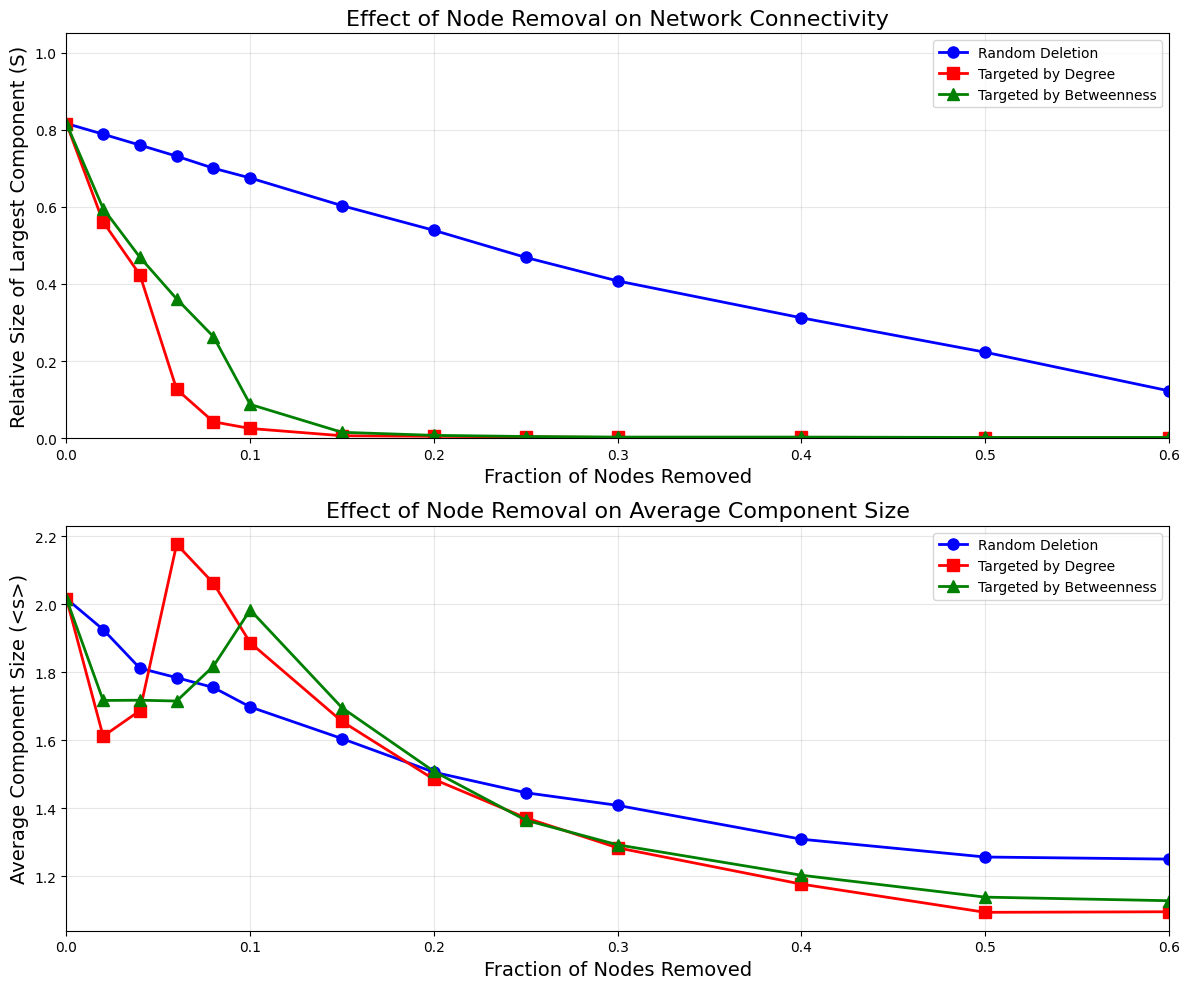

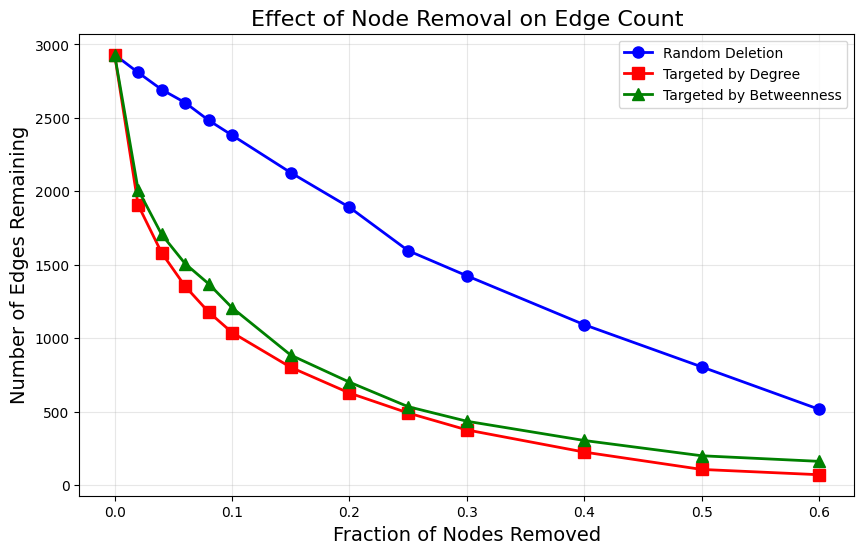

In [14]:
def random_node_deletion(G, fraction_to_remove):
    G_modified = G.copy()
    nodes = list(G.nodes())
    n_remove = int(len(nodes) * fraction_to_remove)
    
    if n_remove > 0:
        np.random.seed(42)  # For reproducibility
        nodes_to_remove = np.random.choice(nodes, size=n_remove, replace=False)
        G_modified.remove_nodes_from(nodes_to_remove)
        
    return G_modified

def targeted_node_deletion(G, fraction_to_remove, target_strategy='degree'):
    G_modified = G.copy()
    nodes = list(G.nodes())
    n_remove = int(len(nodes) * fraction_to_remove)
    
    if n_remove > 0:
        if target_strategy == 'degree':
            node_degrees = dict(G.degree())
            sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node for node, _ in sorted_nodes[:n_remove]]
            
        elif target_strategy == 'betweenness':
            print(f"Calculating betweenness centrality for {len(nodes)} nodes...")
            start_time = time.time()
            if len(nodes) > 1000:
                betweenness = nx.betweenness_centrality(G, k=min(500, len(nodes)))
            else:
                betweenness = nx.betweenness_centrality(G)
            
            end_time = time.time()
            print(f"Betweenness calculation took {end_time - start_time:.2f} seconds")
            sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node for node, _ in sorted_nodes[:n_remove]]
        
        else:
            raise ValueError(f"Unknown target strategy: {target_strategy}")
            
        G_modified.remove_nodes_from(nodes_to_remove)
        
    return G_modified

def calculate_robustness_metrics(G_original, G_modified):
    if len(G_modified.nodes()) > 0:
        connected_components = list(nx.connected_components(G_modified))
        if connected_components:
            largest_cc = max(connected_components, key=len)
            S = len(largest_cc) / len(G_original.nodes())
        else:
            S = 0
    else:
        S = 0

    if len(G_modified.nodes()) > 0:
        connected_components = list(nx.connected_components(G_modified))
        
        if len(connected_components) > 1:
            non_largest_cc = [cc for cc in connected_components if cc != largest_cc]
            
            if non_largest_cc:
                avg_s = np.mean([len(cc) for cc in non_largest_cc])

    else:
        avg_s = 0
    
    return {'S': S, 'avg_s': avg_s }

def analyze_network_robustness(G, deletion_fractions, deletion_strategies):
    results = []
    
    total_iterations = len(deletion_strategies) * len(deletion_fractions)
    current_iteration = 0
    
    for strategy in deletion_strategies:
        for fraction in deletion_fractions:
            current_iteration += 1
            print(f"Processing {strategy} deletion, fraction {fraction:.2f} ({current_iteration}/{total_iterations})")
            
            if strategy == 'random':
                G_modified = random_node_deletion(G, fraction)
            elif strategy == 'targeted_degree':
                G_modified = targeted_node_deletion(G, fraction, target_strategy='degree')
            elif strategy == 'targeted_betweenness':
                G_modified = targeted_node_deletion(G, fraction, target_strategy='betweenness')
            else:
                raise ValueError(f"Unknown strategy: {strategy}")
            
            metrics = calculate_robustness_metrics(G, G_modified)
            
            results.append({
                'strategy': strategy,
                'fraction_removed': fraction,
                'S': metrics['S'],
                'avg_s': metrics['avg_s'],
                'nodes_remaining': G_modified.number_of_nodes(),
                'edges_remaining': G_modified.number_of_edges()
            })
    
    return pd.DataFrame(results)

def plot_robustness_results(results):
    strategies = results['strategy'].unique()
    strategy_styles = {
        'random': {'color': 'blue', 'marker': 'o', 'label': 'Random Deletion'},
        'targeted_degree': {'color': 'red', 'marker': 's', 'label': 'Targeted by Degree'},
        'targeted_betweenness': {'color': 'green', 'marker': '^', 'label': 'Targeted by Betweenness'}
    }

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    for strategy in strategies:
        strategy_data = results[results['strategy'] == strategy]
        style = strategy_styles.get(strategy, {'color': 'black', 'marker': 'x', 'label': strategy})
        
        plt.plot(strategy_data['fraction_removed'], strategy_data['S'], 
                 marker=style['marker'], color=style['color'], 
                 label=style['label'], linewidth=2, markersize=8)
    
    plt.xlabel('Fraction of Nodes Removed', fontsize=14)
    plt.ylabel('Relative Size of Largest Component (S)', fontsize=14)
    plt.title('Effect of Node Removal on Network Connectivity', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max(results['fraction_removed']))
    plt.ylim(0, 1.05)

    plt.subplot(2, 1, 2)
    for strategy in strategies:
        strategy_data = results[results['strategy'] == strategy]
        style = strategy_styles.get(strategy, {'color': 'black', 'marker': 'x', 'label': strategy})
        
        plt.plot(strategy_data['fraction_removed'], strategy_data['avg_s'], 
                 marker=style['marker'], color=style['color'], 
                 label=style['label'], linewidth=2, markersize=8)
    
    plt.xlabel('Fraction of Nodes Removed', fontsize=14)
    plt.ylabel('Average Component Size (<s>)', fontsize=14)
    plt.title('Effect of Node Removal on Average Component Size', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max(results['fraction_removed']))
    
    plt.tight_layout()
    plt.savefig('ypi_robustness_analysis.png', dpi=300)
    print("Saved plot to 'ypi_robustness_analysis.png'")

def find_critical_thresholds(results):
    strategies = results['strategy'].unique()
    
    thresholds = {}
    for strategy in strategies:
        strategy_data = results[results['strategy'] == strategy]
        
        # Find threshold where S drops below 0.5 (half of original largest component)
        below_half = strategy_data[strategy_data['S'] < 0.5]
        if not below_half.empty:
            critical_threshold = below_half['fraction_removed'].min()
            thresholds[strategy] = critical_threshold
        else:
            thresholds[strategy] = "Not reached within testing range"
    
    return thresholds

def additional_robustness_plots(results):
    strategies = results['strategy'].unique()
    strategy_styles = {
        'random': {'color': 'blue', 'marker': 'o', 'label': 'Random Deletion'},
        'targeted_degree': {'color': 'red', 'marker': 's', 'label': 'Targeted by Degree'},
        'targeted_betweenness': {'color': 'green', 'marker': '^', 'label': 'Targeted by Betweenness'}
    }

    plt.figure(figsize=(10, 6))
    for strategy in strategies:
        strategy_data = results[results['strategy'] == strategy]
        style = strategy_styles.get(strategy, {'color': 'black', 'marker': 'x', 'label': strategy})
        
        plt.plot(strategy_data['fraction_removed'], strategy_data['edges_remaining'], 
                 marker=style['marker'], color=style['color'], 
                 label=style['label'], linewidth=2, markersize=8)
    
    plt.xlabel('Fraction of Nodes Removed', fontsize=14)
    plt.ylabel('Number of Edges Remaining', fontsize=14)
    plt.title('Effect of Node Removal on Edge Count', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.savefig('ypi_edges_remaining.png', dpi=300)
    print("Saved plot to 'ypi_edges_remaining.png'")

def part_c_main(G):
    deletion_fractions = np.concatenate([
        np.linspace(0, 0.1, 6),     # 0%, 2%, 4%, 6%, 8%, 10%
        np.linspace(0.15, 0.3, 4),  # 15%, 20%, 25%, 30%
        np.linspace(0.4, 0.6, 3)     # 40%, 50%, 60%
    ])

    deletion_strategies = ['random', 'targeted_degree', 'targeted_betweenness']
    if G.number_of_nodes() > 5000:
        print("Network is very large. Skipping betweenness centrality for performance reasons.")
        deletion_strategies = ['random', 'targeted_degree']
    
    print(f"Running robustness analysis with {len(deletion_fractions)} fraction points and {len(deletion_strategies)} strategies")
    print(f"Network size: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    start_time = time.time()
    results = analyze_network_robustness(G, deletion_fractions, deletion_strategies)
    end_time = time.time()
    print(f"Robustness analysis completed in {end_time - start_time:.2f} seconds")
    results.to_csv('ypi_robustness_results.csv', index=False)
    print("Saved results to 'ypi_robustness_results.csv'")

    print("Generating plots...")
    plot_robustness_results(results)
    additional_robustness_plots(results)

    print("Finding critical thresholds...")
    thresholds = find_critical_thresholds(results)
    
    print("\nCritical thresholds (fraction of nodes removed where S < 0.5):")
    for strategy, threshold in thresholds.items():
        if isinstance(threshold, str):
            print(f"{strategy}: {threshold}")
        else:
            print(f"{strategy}: {threshold:.4f}")

    summary = pd.DataFrame({
        'Strategy': list(thresholds.keys()),
        'Critical Threshold': [thresholds[s] if isinstance(thresholds[s], str) else f"{thresholds[s]:.4f}" 
                               for s in thresholds.keys()]
    })
    summary.to_csv('ypi_robustness_summary.csv', index=False)
    print("Saved summary to 'ypi_robustness_summary.csv'")
    
    return results, thresholds

if __name__ == "__main__" and 'G' in locals():
    results, thresholds = part_c_main(G)